#### 爛上加爛放空策略

##### 爬取TAIFEX成分股

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
from matplotlib import pyplot as plt
import sqlite3 as sqlite
import requests as re
from bs4 import BeautifulSoup
import yfinance as yf

path = 'https://www.taifex.com.tw/cht/9/futuresQADetail'

res = re.get(path)
res = BeautifulSoup(res.text, 'html.parser')

table = res.find_all('table')[0]
tr = table.find_all('tr')
n = len(tr)
list_syb = []
for i in range(1, n):
  td_name_a = tr[i].find_all('td', headers='name_a')[0].text.strip() + '.tw'
  list_syb.append(td_name_a)
  td_name_b = tr[i].find_all('td', headers='name_b')[0].text.strip() + '.tw'
  list_syb.append(td_name_b)



##### yahooFinanceAPI 下載資料

In [ ]:

df = pd.DataFrame()
endDate = dt.datetime.now()
startDate = dt.datetime(2020, 1, 1)

for i in list_syb:  
  dy = yf.Tickers(i).history(start=startDate, end=endDate, interval='1d')    
  dy.columns = [i[0] for i in dy.columns]
  dy.insert(0, 'stock_id', i)
  dy.reset_index(drop=False, inplace=True) 
  df = pd.concat([df, dy], axis=0)
  df.reset_index(drop=True, inplace=True)

#### 重新命名欄位名稱

In [3]:
df.rename(columns={'Date':'date', 'Open':'開盤價', 'High':'最高價', 'Low':'最低價', 'Close':'收盤價'}, inplace=True)
df = df[['date', 'stock_id', '開盤價', '最高價', '最低價', '收盤價']]


#### 建立回測所需資訊

In [35]:
dfc = df.copy()
dfc['date'] = pd.to_datetime(dfc['date'])
dfc.iloc[:, 2:] = dfc.iloc[:, 2:].astype('float')
dfc = dfc[dfc['date']>'2020-01-02']

list_stock_id = np.unique(dfc['stock_id'])
list_date = list(np.unique(dfc['date']))
list_columns_name = [i for i in dfc.columns]
dff = dfc[dfc['stock_id'].isin(list_stock_id)].copy()
dff.sort_values(['date', 'stock_id'], ascending=[True, True])
dff.reset_index(drop=True, inplace=True)


dff['開盤價_昨日'] = dff.groupby('stock_id')['開盤價'].shift(1)
dff['收盤價_昨日'] = dff.groupby('stock_id')['收盤價'].shift(1)
dff['開盤價_明日'] = dff.groupby('stock_id')['開盤價'].shift(-1)
dff.reset_index(drop=True, inplace=True)

cond = dff['收盤價_昨日']<dff['開盤價_昨日']
dff.loc[:, '昨日是否黑K'] = np.where(cond, 1, 0)


# 每天找出最近100日綠K最多的前100名
n = 100
dff['黑K加總'] = dff.groupby(['stock_id'])['昨日是否黑K'].rolling(n).sum().reset_index(drop=True)
dff.dropna(axis=0, inplace=True)
dff.reset_index(inplace=True, drop=True)


k = 100
top = dff.sort_values(['date', '黑K加總'], ascending=[True, False]).copy()
top_res = top.groupby('date').head(k)
top_res.reset_index(drop=True, inplace=True)


#### 計算損益

In [ ]:
cond2 = top_res['最高價'] / top_res['收盤價_昨日'] - 1 >= 0.07
cond3 = top_res['開盤價'] < top_res['收盤價_昨日']
top_res.loc[:, '是否漲停'] = np.where((cond2 & cond3), 1, 0)


In [ ]:
# tax = 0.003 * 0.5
# fee = 0.001425 * 0.4
tax = 0
fee = 0
top_res.loc[:, 'PL_當沖'] = top_res['開盤價'] * 1000 * (1-tax-fee) - top_res['收盤價'] * 1000 * (1 + fee)

In [ ]:
# tax = 0.003
# fee = 0.001425 * 0.4
tax = 0
fee = 0
top_res.loc[:, 'PL_隔日開盤沖'] = top_res['開盤價'] * 1000 * (1-tax-fee) - top_res['開盤價_明日'] * 1000 * (1 + fee)

In [ ]:
# fee_borrow = 0.035 * (1 + 0.25)
fee_borrow = 0
top_res.loc[:, '借券費用'] = top_res['收盤價'] * 1000 * fee_borrow

In [ ]:
cond4 = top_res['是否漲停']==1
top_res.loc[:, 'net_PL'] = np.where(cond4, top_res['PL_隔日開盤沖'] - top_res['借券費用'], top_res['PL_當沖'])

In [ ]:
top_res.loc[:, 'cumPL'] = top_res['net_PL'].cumsum()


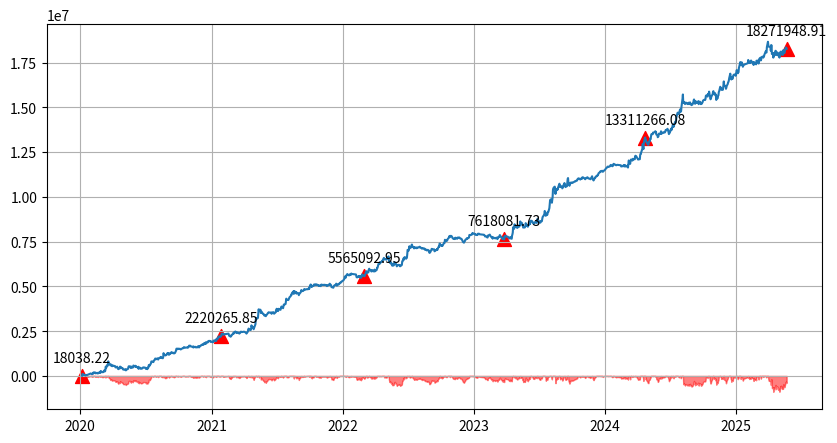

In [68]:
top_res_g = top_res.groupby(['date'])['net_PL'].sum().reset_index(drop=False)

top_res_g['cumPL'] = top_res_g['net_PL'].cumsum()
top_res_g['dd'] = np.array(top_res_g['cumPL']) - np.maximum.accumulate(top_res_g['cumPL'])


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(top_res_g['date'], top_res_g['cumPL'])
ax.grid(True)

for i in np.linspace(0, top_res_g.shape[0]-1, 6):
    num = int(i)
    x = top_res_g['date'].iloc[num]
    y = top_res_g['cumPL'].iloc[num]

    ax.scatter(x, y, marker='^', color='red', s=100)
    ax.annotate(np.round(y, 2), (x, y*1), textcoords="offset points", xytext=(0,10), ha='center')

ax.fill_between(top_res_g['date'], top_res_g['dd'], color='red', alpha=0.5)
plt.show()
plt.close()

#### 回測30次-每日隨機抽取20隻個股並檢視績效損益圖

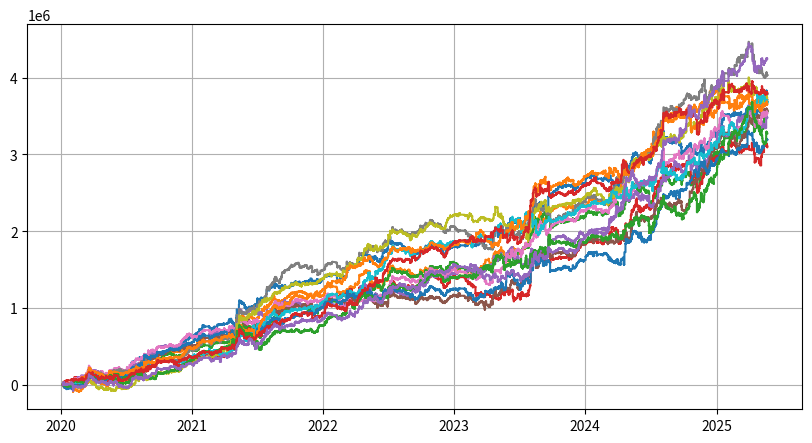

In [69]:
list_date = np.unique(top_res['date'])


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

for k in range(15):
    dfc = pd.DataFrame()
    for i in list_date:
        d = top_res[top_res['date']==i].sample(20)
        dfc = pd.concat([dfc, d], axis=0)

    dfc['cumPL'] = dfc['net_PL'].cumsum(axis=0)
    ax.plot(dfc['date'], dfc['cumPL'])
ax.grid(True)
plt.show()
plt.close()